### Redes Neurais Artificiais - IFES - PPCOMP
### Exercicio 04
### Implementação de ELM

In [167]:
import sklearn
import numpy as np
import pandas as pd
from io import StringIO
import sys
import time

from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_blobs

from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator,ClassifierMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler


# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(74)

## Visão Arquitetural de uma EML

![title](img/ELM-Arquitetura.png)

In [168]:
# Implementação

class ELM (BaseEstimator, ClassifierMixin):


    def __init__(self,
                 hid_n):
         # Parametro hid_n = numero de neuronios escondidos
        self.hid_n = hid_n
        self.beta = 0    

    def sigmoid(self, x):
        sigmoid_range = 34.538776394910684
        x = np.clip(x, -sigmoid_range, sigmoid_range)
        return 1 / (1 + np.exp(-1* x))
        
    def adiciona_bias(self, X):
        self.bias = np.ones(X.shape[0])
        return np.c_[X, self.bias]
    
    def fit(self, X, y):
        np.random.seed()
        X = self.adiciona_bias(X)
        np.random.seed()
        self.W = np.random.uniform(-1, 1, (self.hid_n,  X.shape[1]))
        self.H = np.linalg.pinv(self.sigmoid(np.dot(self.W, X.T))) # https://en.wikipedia.org/wiki/Moore-Penrose_inverse
        self.beta = np.dot(self.H.T, y)        
        return self
           
    def predict(self, X):
        self.H = self.sigmoid(np.dot(self.W, self.adiciona_bias(X).T))
        y=np.dot(self.H.T, self.beta)
        y=(y>0.5).astype(int)
        return y        

### Datasets

In [169]:

dX_AllDatasets={}
dy_AllDatasets={}

# Dataset 1 - make_classification - base com mais exemplos do que características
X, y = make_classification(n_samples=200,n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
dataset_1 = (X, y)
dX_AllDatasets['dataset_1_make_classification']=X
dy_AllDatasets['dataset_1_make_classification']=y

# Dataset 2 - make_classification - base com mais características do que exemplos
# Obs: redução de dimensionalidade aplicada ao dataset
X, y = make_classification(n_samples=100,n_features=125, n_redundant=30, n_repeated=5,
                           random_state=1, n_clusters_per_class=1,flip_y=0.1)

pca = PCA(n_components=2, svd_solver='full') 
X_PCA=pca.fit_transform(X)
dataset_2 = (X_PCA, y)
dX_AllDatasets['dataset_2_make_classification']=X_PCA
dy_AllDatasets['dataset_2_make_classification']=y

# Dataset 3 - make_gaussian_quantiles - base com mais exemplos do que características
X, y = make_gaussian_quantiles(cov=3.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
dataset_3 = (X, y)
dX_AllDatasets['dataset_3_make_gaussian_quantiles']=X
dy_AllDatasets['dataset_3_make_gaussian_quantiles']=y

# Dataset 4 - make_gaussian_quantiles - base com mais características do que exemplos
# Obs: redução de dimensionalidade aplicada ao dataset
X, y = make_gaussian_quantiles(cov=3.,
                                 n_samples=50, n_features=75,
                                 n_classes=2, random_state=1)

pca = PCA(n_components=2, svd_solver='full') 
X_PCA=pca.fit_transform(X)
dataset_4 = (X_PCA, y)
dX_AllDatasets['dataset_4_make_gaussian_quantiles']=X_PCA
dy_AllDatasets['dataset_4_make_gaussian_quantiles']=y

datasets = [dataset_1,
            dataset_2,
            dataset_3,
            dataset_4
           ]

##### Visualização da fronteira de decisão (em diferentes gradientes de cores) para os algoritmos nativos do scikit que possuem o predict_proba implementado.

In [170]:
names = ["MLP", "Perceptron"]

classifiers = [
    MLPClassifier(alpha=1, max_iter=2000),
    Perceptron(tol=1e-3, random_state=0)]

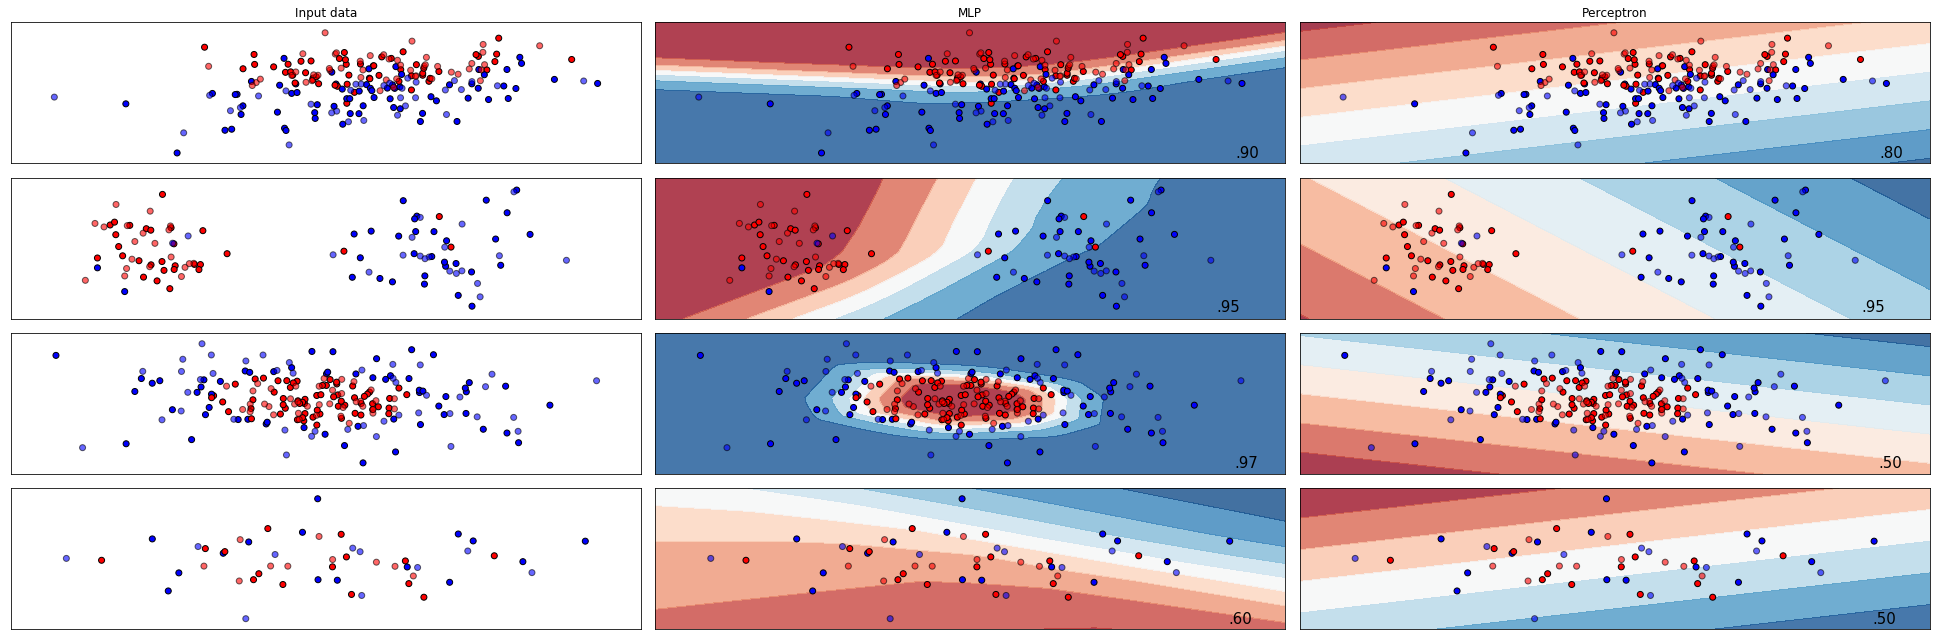

In [187]:
# Plotagem dos meshgrids - Scikitlearn
# URL de referência: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# "step size in the mesh"
h = .02  

figure = plt.figure(figsize=(27, 9))

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [172]:
#Plot de Fronteira de decisão para o ELM implementado
#Referência: https://towardsdatascience.com/easily-visualize-scikit-learn-models-decision-boundaries-dd0fb3747508

def plot_decision_boundaries(X, y, model_class, **model_params):
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

##### Visualização da fronteira de decisão  para a ELM implementada


dataset_1_make_classification
----------------------------------------


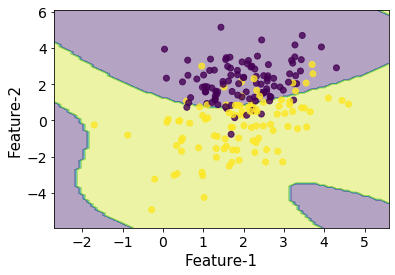

Mean: 0.8302126 Std: 0.0232255(+/-) Best: 0.8717949

dataset_2_make_classification
----------------------------------------


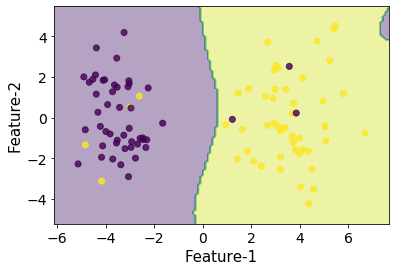

Mean: 0.9309524 Std: 0.0504627(+/-) Best: 1.0000000

dataset_3_make_gaussian_quantiles
----------------------------------------


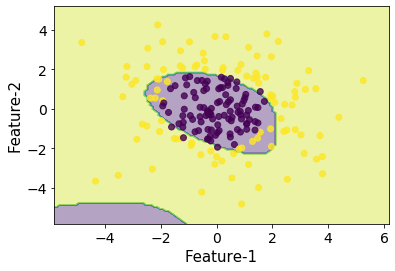

Mean: 0.8550000 Std: 0.0430116(+/-) Best: 0.9250000

dataset_4_make_gaussian_quantiles
----------------------------------------


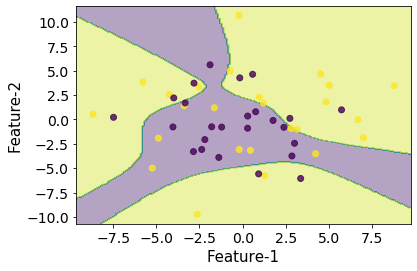

Mean: 0.5200000 Std: 0.2400000(+/-) Best: 0.8000000


In [182]:
for key in dX_AllDatasets.keys():
    print("\n" +"="*40)
    print(key)
    print("-"*40)    
    X,y=dX_AllDatasets[key],dy_AllDatasets[key]
    plt.figure()
    plot_decision_boundaries(X, y, ELM, hid_n=10)
    plt.show()
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
       ('classifier', ELM(10))])
    scores=cross_val_score(pipe, X,y, cv=5)
    print('Mean: %0.7f Std: %0.7f(+/-) Best: %0.7f' % (scores.mean(), scores.std(), scores.max()))

In [157]:
class PerformanceEvaluator():
  def __init__(self, X, y,cv,scaler):
    self.X=X
    self.y=y
    self.cv=cv
    self.scaler=scaler
  def score(self, pipe):
    scores=cross_val_score(pipe, self.X,self.y, cv=self.cv) # (Stratified)KFold
    return scores 
  def evaluate(self, clfs):
    best_overal=0
    for name,clf in clfs:
        if self.scaler==True:
            pipe = Pipeline(steps=[('scaler', StandardScaler()),
                   ('classifier', clf)])
        else:
            pipe = clf
        t_inicio = time.time()
        scores=self.score(pipe)
        t_fim = time.time()
        print('Mean: %0.7f Std: %0.7f(+/-) Best: %0.7f Time: %.2f(s) [%s]' % (scores.mean(), scores.std(), scores.max(),t_fim-t_inicio,name))
        if (scores.mean()>best_overal):
            best_overal=scores.mean()
            best_pipe=pipe
            best_clf_name=name    
    print('Best Estimator: ',best_clf_name)        

In [188]:
# Impressão de Tabela comparativa com a validação cruzada dos classificadores 

### Parametros complementares ###
# cross-validation folds
cv = 5
# habilita ou nao scaler (standard scaler)
scaler = False
#################################

clfs = [
    ('Perceptron',Perceptron(tol=1e-3, random_state=0)),
    ('MLP',MLPClassifier(alpha=1, max_iter=2000)),
    ('ELM',ELM(10))
]

for key in dX_AllDatasets.keys():
    print("\n" +"="*40)
    print(key)
    print("-"*40)    
    X,y=dX_AllDatasets[key],dy_AllDatasets[key]
    pe = PerformanceEvaluator(X,y,cv,scaler)
    pe.evaluate(clfs)


dataset_1_make_classification
----------------------------------------
Mean: 0.8349687 Std: 0.0800088(+/-) Best: 0.8780488 Time: 0.01(s) [Perceptron]
Mean: 0.8653408 Std: 0.0234660(+/-) Best: 0.8974359 Time: 0.42(s) [MLP]
Mean: 0.8405910 Std: 0.0448522(+/-) Best: 0.9230769 Time: 0.00(s) [ELM]
Best Estimator:  MLP

dataset_2_make_classification
----------------------------------------
Mean: 0.7993233 Std: 0.1848642(+/-) Best: 0.9500000 Time: 0.01(s) [Perceptron]
Mean: 0.9309524 Std: 0.0504627(+/-) Best: 1.0000000 Time: 0.31(s) [MLP]
Mean: 0.9309524 Std: 0.0504627(+/-) Best: 1.0000000 Time: 0.02(s) [ELM]
Best Estimator:  MLP

dataset_3_make_gaussian_quantiles
----------------------------------------
Mean: 0.5850000 Std: 0.0888819(+/-) Best: 0.7000000 Time: 0.01(s) [Perceptron]
Mean: 0.9600000 Std: 0.0200000(+/-) Best: 0.9750000 Time: 1.27(s) [MLP]
Mean: 0.8850000 Std: 0.0538516(+/-) Best: 0.9500000 Time: 0.00(s) [ELM]
Best Estimator:  MLP

dataset_4_make_gaussian_quantiles
-------------

##### Análise dos resultados

O primeiro dataset é linearmente separável porém com uma dificil separação dos elementos na fronteira (concorrência de classes na região). Isto favorece os classificadores não lineares (MPL,ELM) devido a sua maior adaptabiliade e consequente ajuste da fronteira de separação.

O segundo dataset é composto por 2 clusters com centroides bem definidos com erros sendo provocados pelo parâmetro de ruído (10%). De uma maneira geral todos os classificadores obtiveram bom desempenho.

O terceiro dataset gerou classes concentricas no espaço fazendo com que as redes se destacassem na separação das mesmas. O resultado do Perceptron foi desastroso para este cenário, o que esperado pela característica do classificador.

O quarto e ultimo dataset sofreu redução de dimensionalidade (como o segundo) porém as features representativas finais foram de dificil separação o que provocou desemepenho o ruim nos 3 classificadores.

Um ponto de destaque para a ELM foi o seu tempo de execução, obtendo bons resultados mesmo em cenários de maior complexidade de separação (dataset 3) quando comparada com a MLP.